# A simple generator of names

This is a character-level predictor: it predicts the next character in a sequence given an input sequence.  
To predict the next character the baseline is using a simple lookup table based on the character frequency while a neural network (specifically a Convolutional Neural Netowrk, CNN) allows to get better results.  
It's a classic NLP example, this one is based on a lecture from Karpathy.

## Read the dataset (names)
The input dataset is just a text file of names. Could be anything, this one is a list of given names.

In [1]:
words = open('../datasets/names.txt', 'r').read().splitlines()

In [2]:
len(words)

32033

The dataset contains more than 32k english given names, for example the first 8 names are:

In [3]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

A **bigram** is a two-character slice of a word.      
Let's see the first 3 names' bigrams, row-by-row.

It's more cleare if we add tags to the start (\<S\>) and to the end (\<E\>) of each name:

In [4]:
for word in words[:3]:
    chs = ['<S>'] + list(word) + ['<E>']
    for char1,char2 in zip(chs,chs[1:]):
        print (char1, char2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


## build the bigram frequency dictionary 

The idea is that we can count the frequency of each character in the bigram, including when it's at the start or the end of a name. And we use this frequency as the probability each bigram can happen in the dataset. From there we can predict new names based on the relative frequency.   
So first we build a dictionary with each bigram and how many times it appears.

In [5]:
b = {} # dictionary
for word in words[:3]:
    nameChars = ['<S>'] + list(word) + ['<E>'] # extract each name and prefix/suffix it with special chars (list)
                            # e.g. first name = ['<S>', 'e', 'm', 'm', 'a', '<E>']
    for start,end in zip(nameChars,nameChars[1:]):   # zip() aggregates two lists in tuples, to form the bigrams
        bigram = (start, end)
        b[bigram] = b.get(bigram, 0) + 1  # add counter for this bigram

In [6]:
sorted(b.items(), key = lambda kv: -kv[1])[:10] # let's see the first ten

[(('a', '<E>'), 3),
 (('<S>', 'e'), 1),
 (('e', 'm'), 1),
 (('m', 'm'), 1),
 (('m', 'a'), 1),
 (('<S>', 'o'), 1),
 (('o', 'l'), 1),
 (('l', 'i'), 1),
 (('i', 'v'), 1),
 (('v', 'i'), 1)]

In the first three names, the "a" appears 3 times as end of the name and this is the most often bigram.  
  
Now we try this approach to the entire dataset and we will use a pyTorch tensor to build the frequency dictionary.  
Note that we use the semicolon ; to separate the names.  

In [7]:
import torch

In [8]:
vocabSize = 27 # there are 27 chars in the latin alphabet

N = torch.zeros((vocabSize,vocabSize), dtype=torch.int32) # matrix of tensors, default type is float32


In [9]:
# build the vocabulary of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))  # ['a', 'b', 'c', ... 'x', 'y', 'z']
s2i = {s:i+1 for i,s in enumerate(chars)} 
s2i[';'] = 0 # we use the semicolon as the special character for start and end (mapped to zero)

Each character is now mapped to an integer, including the semicolon separator that is mapped to 0:

In [10]:
s2i['m']

13

In [11]:
s2i[';']

0

Again we build the bigrams with their frequency, this time for all names:

In [12]:
for word in words:
    nameChars = [';'] + list(word) + [';']  # extract name, add start/end and split in chars
    for char1,char2 in zip(nameChars,nameChars[1:]):
        ix1 = s2i[char1] # index of first char in bigram
        ix2 = s2i[char2] # index of second char in bigram
        N[ix1, ix2] += 1  # counter for this bigram added in the matrix

In [13]:
i2s = {i:s for s,i in s2i.items()}  # reverse: get bigram from index

In [14]:
i2s[13]

'm'

Let's visualize this frequency matrix:

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

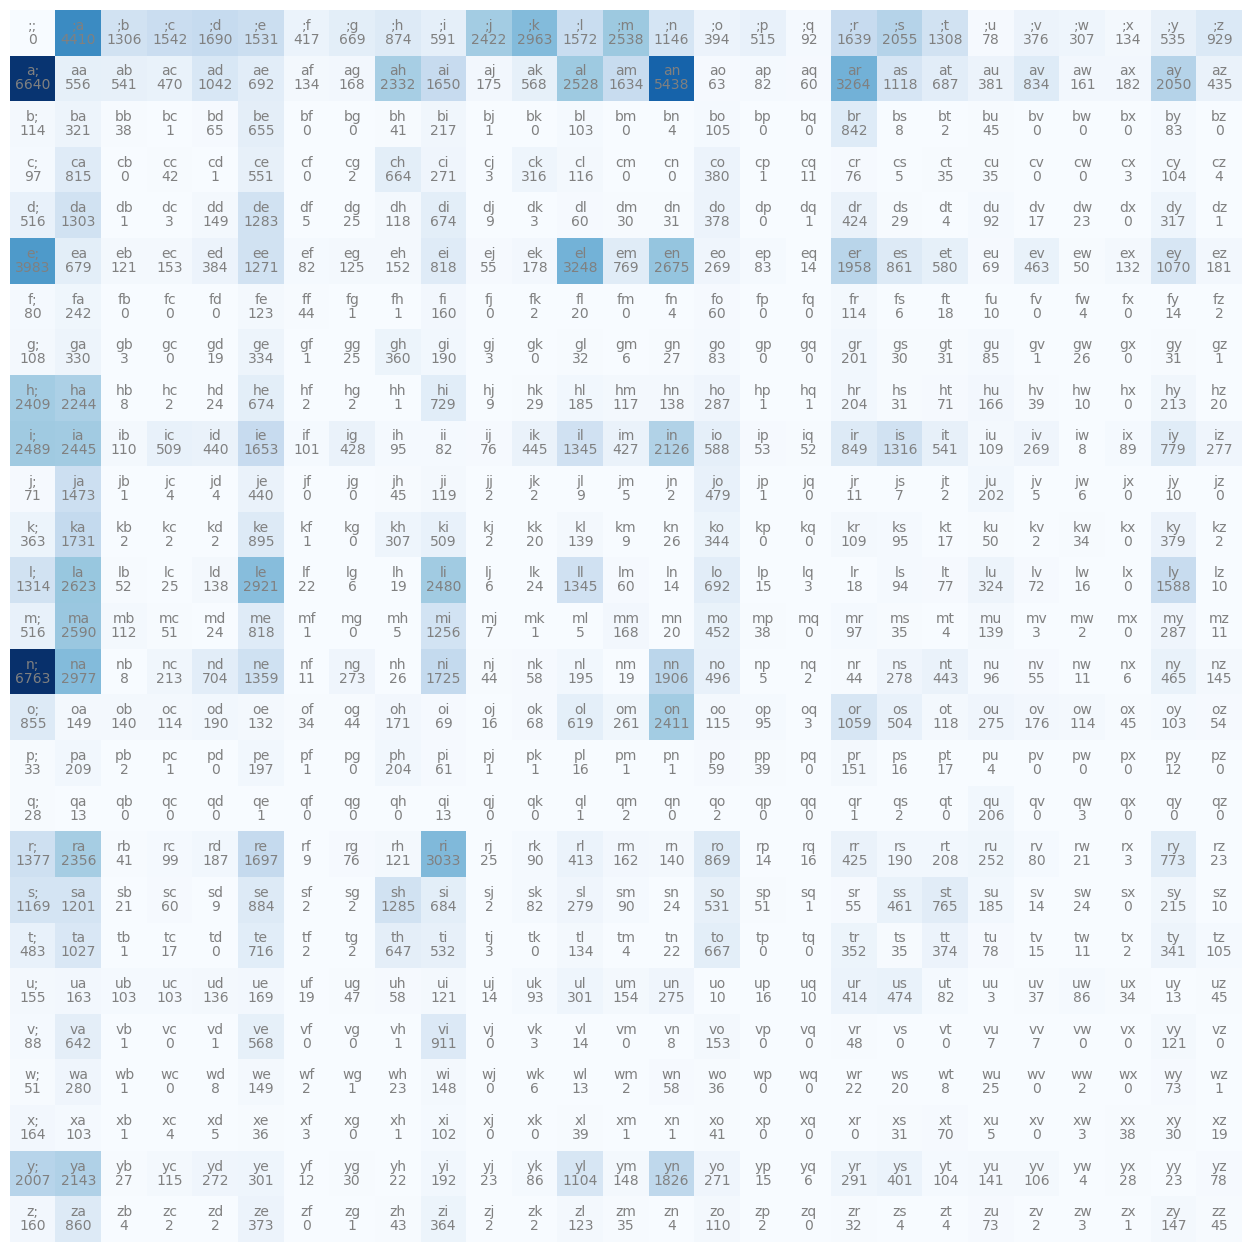

In [16]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(vocabSize):
    for j in range (vocabSize):
        chstr = i2s[i] + i2s[j]
        plt.text(j,i,chstr,ha='center', va='bottom',color='gray')
        plt.text(j,i, N[i,j].item(), ha='center', va = 'top', color='gray')
plt.axis('off');

This is telling us how many times a bigram occurs, e.g. "ri" happened more than 3000 times (out of 32K)  
The character ";" tells that its other char in the bigram is starting or ending.  
So there are more than 13K names ending with n (bigram = 'n;')

##  Define a baseline
A simple baseline would be to consider the matrix above a uniform distribution and to sample chars randomly from it

In [17]:
g = torch.Generator().manual_seed(1234) # to be deterministic

So now we can write a loop for the sampling and generating the next character.

we use torch.multinomial (add link) to sample from this distribution and we stop when a semicolon (number 0) is extracted as sample

In [18]:
for i in range(10):
    out = []
    ix = 0
    while True:
        p = torch.ones(vocabSize) / float(vocabSize) # a list of 27 tensors each one = 0.37 = 1/27 so they all have same prob
        
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
        out.append(i2s[ix])
        if ix == 0:
            break
    print(''.join(out))

yyawbxpffamjawmitzxtfla;
rm;
drnsaptluitmeisyrshotobxy;
n;
mqweaukfu;
;
huczvqiqooulnwzbebedapmiooyfcolamqmhqaouxdiwund;
k;
wdlsn;
tgizjnazevzwuhsueajtznfrbrnaqfmsqggnqmsautfmrlgim;


Terrible. This is what you get from a model untrained: garbage  


Let's try to evaluate the quality of this model.  
We have 27 letters so each one should have equal probability = 1/27 = 4% to be sampled.   
Everything above it it means we have gained some knowledge

## A better baseline
We create a probability table from the frequency matrix, just dividing the frequency by the total

In [19]:
P = N.float()  # initialise the probability table P to the frequency matrix N
P /= P.sum(1, keepdim = True)  #look at torch.sum and the broadcasting and it's a inplace operation

In [20]:
def sample(n):
    for i in range(n):
        out = []
        ix = 0 # initialisation
        while True:
            p = P[ix]  # now sample using the probability table P
            ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
            out.append(i2s[ix])
            if ix == 0:
                break
        print(''.join(out))

In [21]:
sample(10)

parigaramah;
mii;
lya;
klahuwan;
kin;
e;
gamenn;
dee;
a;
kann;


It's a bit better.  
Will now try to improve the model via a neural network

GOAL: maximize likelihood of the data wrt model parameters (statistical modeling)  
equivalent to maximizing the log likelihood (because log is monotonic)   

In [22]:
def getLossForExampleName(name):
        # initialization
    logLikelihood = 0.0
    count = 0 # just a counter to normalize
    
    print("bigram = likelihood & log(likelihood)")
    print("-------------------------------------")
    for word in [name]:
        chs = [';'] + list(word) + [';']
        for char1,char2 in zip(chs,chs[1:]):
            ix1 = s2i[char1]
            ix2 = s2i[char2]
            prob = P[ix1, ix2]
            logprob = torch.log(prob)
            logLikelihood += logprob
            count += 1
        
            print(f'{char1}{char2} = {prob:.4f} & {logprob:.4f}')
        
    print(f'log(likelihood) for name {name} is: {logLikelihood}')
    
    return(logLikelihood, count)

In [23]:
LL, n = getLossForExampleName('max')

bigram = likelihood & log(likelihood)
-------------------------------------
;m = 0.0792 & -2.5354
ma = 0.3899 & -0.9418
ax = 0.0054 & -5.2267
x; = 0.2353 & -1.4469
log(likelihood) for name max is: -10.150785446166992


This is equivalent to minimizing the negative log likelihood (because is negative)  
and is equivalent to minimizing the average negative log likelihood:  

In [24]:
negLL = -LL # loss function, lower is better
print(f'Negative log(likelihood) for name Max is: {negLL}')
print(f'Average negative log(likelihood) is: {negLL/n}') #average

Negative log(likelihood) for name Max is: 10.150785446166992
Average negative log(likelihood) is: 2.537696361541748


Some bigrams have higher probabilities such as ma = 39% but others like the bigram ax have lower probability, making the total loss for the name Max equal to 2.54 (not high).  
  
## Handling zero probability
One problem when using the log(likelihood) as a measure is that could return infinite if the probability is zero.  
For example, for bigrams that are not present in the names of our matrix:

In [25]:
    # example: the non-existing name Maxq
getLossForExampleName('maxq');

bigram = likelihood & log(likelihood)
-------------------------------------
;m = 0.0792 & -2.5354
ma = 0.3899 & -0.9418
ax = 0.0054 & -5.2267
xq = 0.0000 & -inf
q; = 0.1029 & -2.2736
log(likelihood) for name maxq is: -inf


You can see that maxq has zero probability (infiinite loss) that's because the bigram xq never come in the training set. See its probability above: it's zero.  
To fix it, we can add 1 to every count so there will be no zero count bigram. This is a very simple version of  [smoothing](https://en.wikipedia.org/wiki/Smoothing).  

In [26]:
P = (N+1).float()  # smoothing
P /= P.sum(1, keepdim = True)  

In [27]:
LL,n = getLossForExampleName('maxq');

bigram = likelihood & log(likelihood)
-------------------------------------
;m = 0.0792 & -2.5358
ma = 0.3885 & -0.9454
ax = 0.0054 & -5.2220
xq = 0.0014 & -6.5848
q; = 0.0970 & -2.3331
log(likelihood) for name maxq is: -17.62124252319336


In [28]:
negLL = -LL # loss function, lower is better
print(f'Negative log(likelihood) for name Maxq is: {negLL}')
print(f'Average negative log(likelihood) is: {negLL/n}') #average

Negative log(likelihood) for name Maxq is: 17.62124252319336
Average negative log(likelihood) is: 3.5242486000061035


The loss for name Maxq is higher than for name Max, as expected.  
Now we have number that make sense, no more errors.  
  
Let's generate again ten names to see everything is still working:

In [29]:
sample(10)

mailekh;
maynna;
melyzyo;
nalonitarousharislleere;
jaiereylebemita;
joustay;
taynnatyaialvi;
myan;
n;
pr;


this is the baseline.. now we train a simple Neural Network

## Train a simple Neural Network

We first create the training set of all bigrams  

In [30]:
import torch.nn.functional as pyTF

In [31]:
# build the dataset

def buildDataset(words):
    
    X,Y = [],[]

    for word in words:
        chs = [';'] + list(word) + [';']
        for char1,char2 in zip(chs,chs[1:]):
            ix1 = s2i[char1]
            ix2 = s2i[char2]
                
            ix1 = s2i[char1]
            ix2 = s2i[char2]
        
            X.append(ix1)
            Y.append(ix2)    
                
    return (torch.tensor(X), torch.tensor(Y))

In [32]:
xs,ys = buildDataset(words)

In [33]:
num = xs.nelement()
print ("number of examples: ", num)

number of examples:  228146


In [34]:
# weight initialisation
W = torch.randn((vocabSize, vocabSize), generator = g, requires_grad = True) # initialise the weights using normal distribution

In [35]:
# gradient pass
for k in range(5):  # only few steps
        # forward pass
    xEncoded = pyTF.one_hot(xs, num_classes=vocabSize).float() # need to cast to float, as torch's one hot returns a matrix of integers
    logits = xEncoded @ W  # log counts, use matrix multiplication operation, dot product, shape is 5 by 27
    counts = logits.exp()  # equivalent to N
    probs = counts / counts.sum(1, keepdims = True)  # softmax
    loss = -probs[torch.arange(num), ys].log().mean()
    print (loss.item()) 
    
        # backward pass
    W.grad = None # set gradient to zero
    loss.backward()
    
        # update the weights
    W.data += -50 * W.grad  # this is the learning rate

3.757784843444824
3.3912317752838135
3.1747286319732666
3.0374677181243896
2.942314624786377


The loss is correctly decreasing but we get more or less the same result loss of the baseline and that is understandable, we did not add any new information. But this approach is more flexible and we can increase the complexity of the NN and we can consider n characters instead of only one (instead, the baseline is not scalable basically, cannot keep too many info in the table).

Finally we sample from this simple Neural Network:

In [36]:
#g = torch.Generator().manual_seed(1234) # to be deterministic

for i in range(10):
    out = []
    ix = 0
    while True:

            #forward pass
        xEncoded = pyTF.one_hot(torch.tensor([ix]), num_classes=27).float() # need to cast to float, as torch's one hot returns a matrix of integers
        logits = xEncoded @ W  # log counts, use matrix multiplication operation, dot product, shape is 5 by 27
        counts = logits.exp()  # equivalent to N
        probs = counts / counts.sum(1, keepdims = True)  # softmax
    
        ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        out.append(i2s[ix])
        if ix == 0:
            break
    print(''.join(out))

txpo;
sixlelwhs;
ynoix;
sorwhmcupxdsqadgfcvohla;
doo;
abcri;
wavgrbeanrepppd;
kcyihyarano;
sah;
jayyibzyrblxziciabc;


# MLP

We are now training a more sophisticated neural network, following the architecture that Bengio et al. described in their paper from 2003.  
We are using the functions available from pyTorch.  

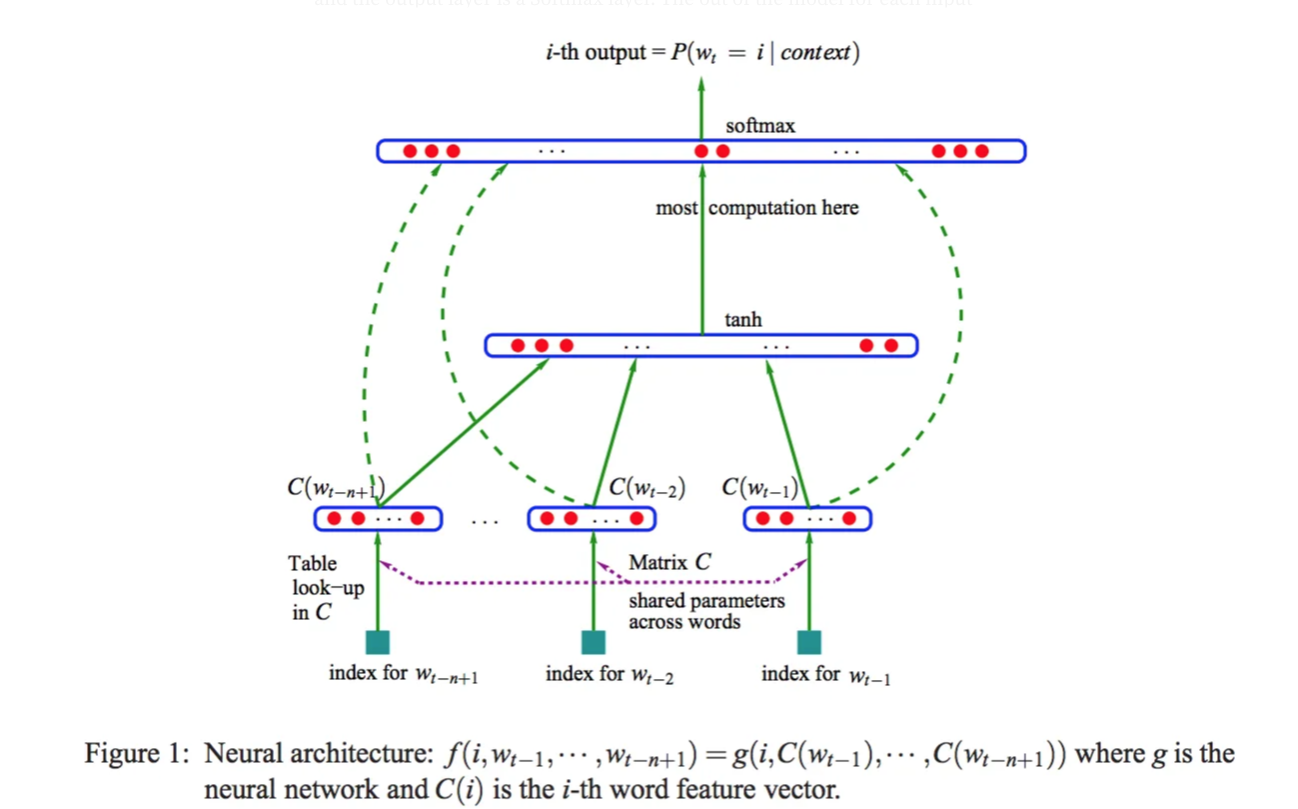

The main idea is to consider more characters (a context) to predict the next one.  
For example considering 3 chars:

In [37]:
blockSize = 3 # context length=how many chars taken to predict the next one
X,Y = [],[]

for word in words[:3]:
    print(word)
    context = [0] * blockSize # start with a padded context
    for char in word+';':
        ix = s2i[char]
        X.append(context)
        Y.append(ix)
        print(''.join(i2s[i] for i in context), '-->', i2s[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
;;; --> e
;;e --> m
;em --> m
emm --> a
mma --> ;
olivia
;;; --> o
;;o --> l
;ol --> i
oli --> v
liv --> i
ivi --> a
via --> ;
ava
;;; --> a
;;a --> v
;av --> a
ava --> ;


In [38]:
# build the dataset

def buildDatasetMLP(words):
    
    blockSize = 3 # context length=how many chars taken to predict the next one
    X,Y = [],[]

    for word in words:
        context = [0] * blockSize # start with a padded context

        for char in word+';':
            ix = s2i[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append   
                
    return (torch.tensor(X), torch.tensor(Y))

In [39]:
(X,Y) = buildDatasetMLP(words)

In [40]:
X.shape  #check: must be 228146, 3

torch.Size([228146, 3])

In [41]:
Y.shape  #check: must be 228146

torch.Size([228146])

In [42]:
C = torch.randn((vocabSize,2), generator=g) #  context space
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [43]:
def initParameters(size=100):
    C = torch.randn((vocabSize,2), generator=g) # context space
    w1 = torch.randn((6,size), generator=g)  # 6=3x2  weights
    b1 = torch.randn(size, generator=g)  # bias
    w2 = torch.randn((size,vocabSize), generator=g)
    b2 = torch.randn(27, generator=g)
    
    param = [C,w1,b1,w2,b2]
    
    print(f'Total number of parameters = {sum(p.nelement() for p in param)}')
    return (param)

In [44]:
parameters = initParameters()

Total number of parameters = 3481


We can use the special tensor function *cross entropy*, which is more efficient use of memory

In [45]:
for p in parameters:
    p.requires_grad = True

In [46]:
C = parameters[0]
w1 = parameters[1]
b1 = parameters[2]
w2 = parameters[3]
b2 = parameters[4]

In [47]:
lre = torch.linspace(-3, 0, 1000) # let's torch find out the optimal learning rate between 0.001 and 1
lrs = 10**lre

In [48]:
lri = []
losses = []

for i in range(1000):
    
    #minibatch construct, otherwise each iteration will take longer time, even if the gradient is not exact
    ix = torch.randint(0, X.shape[0], (32,))
    
    #forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0],6) @ w1 + b1)   # hidden layer
    logits = h @ w2 + b2
    loss = pyTF.cross_entropy(logits, Y[ix])
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()  #populate the gradients

    lr = lrs[i]
    # parameters update
    for p in parameters:
        p.data += -lr * p.grad  # this is the learning rate
        
        
    lri.append(lre[i])
    losses.append(loss.item())

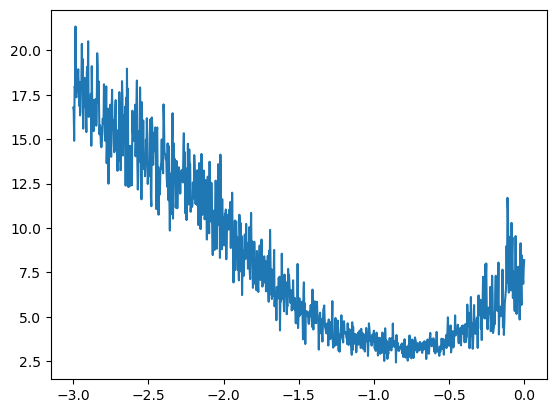

In [49]:
plt.plot(lri,losses)

turns out 0.1 was a good learning rate (exp 1)

you can see the direction is not always correct because of the minibatch

Finally we split the dataset into training, test and validate subsets and use them to train a bigger neural networks build in a modular way so we can play with the layers and fine tune.  
And we increase the context block size to 8 characters.

In [50]:
import random
random.shuffle(words)


In [51]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + ';':
      ix = s2i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [52]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182387, 8]) torch.Size([182387])
torch.Size([22847, 8]) torch.Size([22847])
torch.Size([22912, 8]) torch.Size([22912])


In [53]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(i2s[ix.item()] for ix in x), '-->', i2s[y.item()])


;;;;;;;; --> j
;;;;;;;j --> u
;;;;;;ju --> d
;;;;;jud --> a
;;;;juda --> s
;;;judas --> ;
;;;;;;;; --> l
;;;;;;;l --> u
;;;;;;lu --> c
;;;;;luc --> e
;;;;luce --> r
;;;lucer --> o
;;lucero --> ;
;;;;;;;; --> k
;;;;;;;k --> y
;;;;;;ky --> l
;;;;;kyl --> y
;;;;kyly --> n
;;;kylyn --> n
;;kylynn --> ;


each layer has weight and bias (think about the W1,w2 and b1,b2 variables previously set).

In [54]:
# Embedding characters into vectors
# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


In [55]:
# Linear layer
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init (there is a paper)
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])



In [56]:
# Batch Normalisation layer
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalise to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]



In [57]:
# hidden layers non-linearity
# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []



In [58]:
# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [59]:
torch.manual_seed(42); # seed rng for reproducibility


And now we put all together the layers

In [60]:
# hierarchical network
nEmbd = 24 # the dimensionality of the character embedding vectors (the last layer)
nHidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocabSize, nEmbd),
  FlattenConsecutive(2), Linear(nEmbd * 2, nHidden, bias=False), BatchNorm1d(nHidden), Tanh(),
  FlattenConsecutive(2), Linear(nHidden*2, nHidden, bias=False), BatchNorm1d(nHidden), Tanh(),
  FlattenConsecutive(2), Linear(nHidden*2, nHidden, bias=False), BatchNorm1d(nHidden), Tanh(),
  Linear(nHidden, vocabSize),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [61]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  #print(layer.__class__.__name__, ':', tuple(layer.out.shape))
  print(layer.__class__.__name__)


Embedding
FlattenConsecutive
Linear
BatchNorm1d
Tanh
FlattenConsecutive
Linear
BatchNorm1d
Tanh
FlattenConsecutive
Linear
BatchNorm1d
Tanh
Linear


In [62]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = pyTF.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 50000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

print(f'Final step: {loss.item():.4f}') # last one


      0/ 200000: 3.3068
  50000/ 200000: 2.1875
 100000/ 200000: 1.7453
 150000/ 200000: 1.8458
Final step: 1.5655


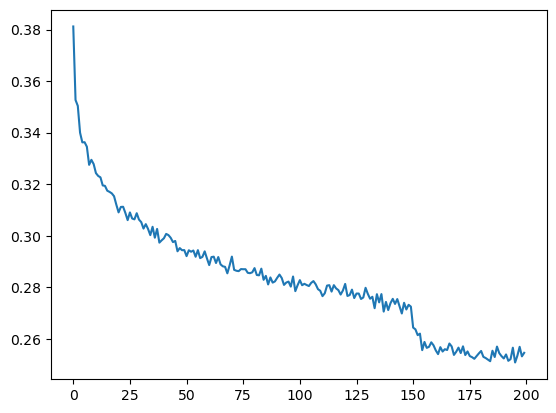

In [63]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


the drop down is the learning rate decay.  
Finally we check the loss on the train and on the validation set, they should not be too different otherwise it's an indication of over-fitting:

In [64]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [65]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = pyTF.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7673193216323853
val 1.9842778444290161


All good. Let's sample

In [66]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = pyTF.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special ';' ending token, break
      if ix == 0:
        break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

apolj;
chosetthem;
zarachi;
queen;
jwan;
amylie;
broxx;
logene;
kaystin;
teagon;
darest;
onylania;
valynn;
seva;
cassedine;
remit;
dawye;
janicy;
niema;
kennah;


Increasing the block size (e.g. to 10) and the total number of parameters embeddings (up to 500) the training error improved (i.e. around 1.78) but the validation and test errors remain around 1.98; No big improvements. 
